In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import numpy as np
import pandas as pd
DATA_DIR = '/kaggle/input/landmass/landmass_salt.h5'
train = pd.read_hdf(DATA_DIR, key='train')

In [4]:
train.label.value_counts()

label
horizon99    9384
chaotic99    5139
salt99       1891
fault99      1251
Name: count, dtype: int64

In [4]:
from skimage.transform import resize
import cv2
def upsample(img):
    return cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

In [5]:
# Train-test split
X = np.array(train.image.map(upsample).tolist())
#X = np.repeat(X.reshape(-1,128,128,1), 3, axis=-1)
X = X / 255.0
y = train.label
#depth = train.z


In [6]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y.astype('category').cat.codes, num_classes=4)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

In [9]:
X_train.shape

(14132, 128, 128)

In [10]:
X_test.shape

(3533, 128, 128)

In [8]:
import numpy as np

# Convert one-hot to class labels
class_counts = np.sum(y_train, axis=0)

# Print class distribution
for i, count in enumerate(class_counts):
    print(f"Class {i}: {int(count)} samples")


Class 0: 4111 samples
Class 1: 1001 samples
Class 2: 7507 samples
Class 3: 1513 samples


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_model():

# Define the CNN model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

# Summary of the model
#model.summary()


# Centeralized Training

In [11]:
model = create_model()

In [12]:

# Train the model on the fold
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6951 - loss: 0.7788 - val_accuracy: 0.9915 - val_loss: 0.0522
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9768 - loss: 0.0835 - val_accuracy: 0.9915 - val_loss: 0.0253
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9884 - loss: 0.0427 - val_accuracy: 0.9935 - val_loss: 0.0208
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9919 - loss: 0.0346 - val_accuracy: 0.9960 - val_loss: 0.0132
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9924 - loss: 0.0272 - val_accuracy: 0.9952 - val_loss: 0.0120
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9924 - loss: 0.0262 - val_accuracy: 0.9946 - val_loss: 0.0131
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9926 - loss: 0.0234 - val_accuracy: 0.9975 - val_loss: 0.0090
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9950 - loss: 0.0203 - val_accur

In [18]:
model.evaluate(X_test, y_test, verbose=0)

[0.002874881261959672, 0.9991508722305298]

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


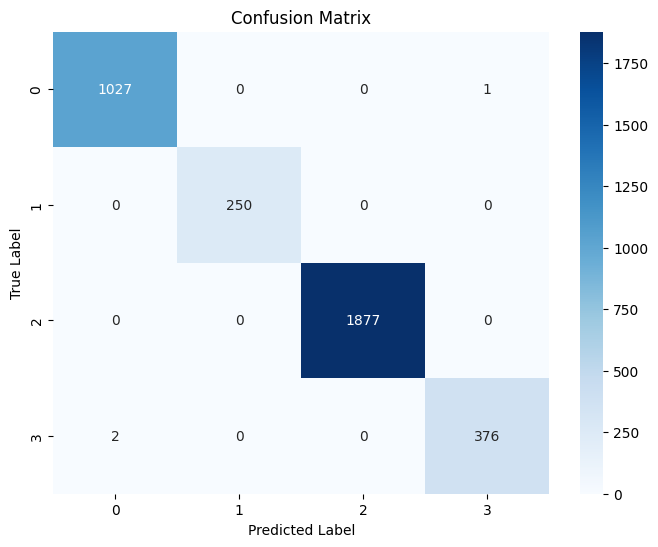

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on validation data
y_pred = np.argmax(model.predict(X_test), axis=1)  # Get class with highest probability
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices if needed

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


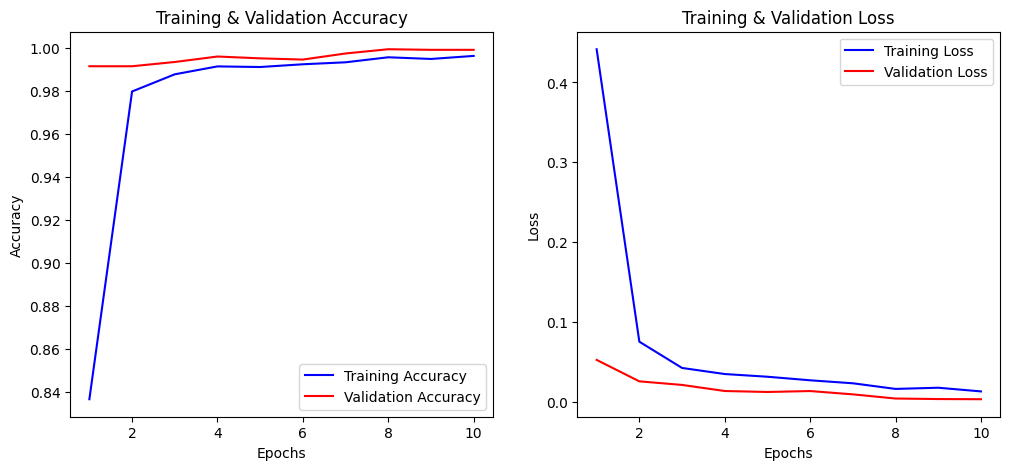

In [14]:
import matplotlib.pyplot as plt

# Assuming you have saved the model's history
def plot_training_history(history):
    """Plots training and validation accuracy & loss."""
    
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', None)  # Some models may not have val_acc
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(history)


# Federated training

In [14]:
import numpy as np

def split_data_non_iid(x, y, num_clients):
    """
    Splits data into non-IID distribution where clients receive different class distributions.
    
    Args:
        x (numpy array): Feature dataset of shape (N, 128, 128, 3).
        y (numpy array): Labels corresponding to x (shape (N, num_classes)).
        num_clients (int): Number of clients.
    
    Returns:
        list: A list of tuples, where each tuple contains (x, y) for each client.
    """
    client_data = []
    
    # Get the class labels (assuming y is one-hot encoded)
    unique_classes = np.unique(np.argmax(y, axis=1))  # Using np.argmax to get class indices
    
    # Create a dictionary to store indices of each class
    class_indices = {cls: np.where(np.argmax(y, axis=1) == cls)[0] for cls in unique_classes}
    
    # Shuffle the indices within each class
    for cls in class_indices:
        np.random.shuffle(class_indices[cls])

    # Total number of samples in the dataset
    total_samples = len(x)
    
    # Calculate number of shards and how many each client will get
    num_shards = len(x) // num_clients  # Number of shards
    shards = []

    # Create shards by selecting samples from different classes
    for cls in unique_classes:
        num_samples_per_class = len(class_indices[cls])
        shard_size = num_samples_per_class // num_clients  # Number of samples per shard for each client
        
        for i in range(num_clients):
            start_idx = i * shard_size
            end_idx = start_idx + shard_size
            shards.append(class_indices[cls][start_idx:end_idx])

    # Distribute shards among clients
    np.random.shuffle(shards)  # Shuffle the shards before distributing

    for i in range(num_clients):
        client_x = []
        client_y = []

        # Assign different shards to each client
        for shard in shards[i::num_clients]:
            client_x.append(x[shard])
            client_y.append(y[shard])
        
        client_x = np.concatenate(client_x, axis=0)
        client_y = np.concatenate(client_y, axis=0)
        
        client_data.append((client_x, client_y))

    # Verify if the total samples match the original dataset size
    total_assigned_samples = sum([len(client[0]) for client in client_data])
    if total_assigned_samples != total_samples:
        print(f"Warning: Mismatch in total samples. Expected: {total_samples}, Got: {total_assigned_samples}")
    
    return client_data



In [21]:
# Ensure the same split is used in both calculations
num_clients = 3
client_data = split_data_non_iid(X_train, y_train, num_clients)
print_class_distribution(client_data)

# Verify shapes again
for i, (X, y) in enumerate(client_data):
    print(f"Client {i+1}: X shape: {X.shape}, y shape: {y.shape}")


Client 1 Class Distribution:
Class 0: 0.0 samples
Class 1: 333.0 samples
Class 2: 5004.0 samples
Class 3: 504.0 samples
----------------------------------------
Client 2 Class Distribution:
Class 0: 1370.0 samples
Class 1: 666.0 samples
Class 2: 0.0 samples
Class 3: 504.0 samples
----------------------------------------
Client 3 Class Distribution:
Class 0: 2740.0 samples
Class 1: 0.0 samples
Class 2: 2502.0 samples
Class 3: 504.0 samples
----------------------------------------
Client 1: X shape: (5841, 128, 128), y shape: (5841, 4)
Client 2: X shape: (2540, 128, 128), y shape: (2540, 4)
Client 3: X shape: (5746, 128, 128), y shape: (5746, 4)


In [16]:
import numpy as np

def print_class_distribution(client_data):
    for i, (X, y) in enumerate(client_data):
        print(f"Client {i+1} Class Distribution:")
        class_counts = np.sum(y, axis=0)  # Sum across each class
        for j, count in enumerate(class_counts):
            print(f"Class {j}: {count} samples")
        print("-" * 40)



In [22]:
# Initialize the global model
global_model = create_model()

# Each local model starts with the same initial weights
initial_weights = global_model.get_weights()

In [23]:
# Number of rounds for federated learning
num_rounds = 20  
localacc =[]
globalacc=[]
for round_num in range(num_rounds):
    print(f"Round {round_num + 1}/{num_rounds}")

    local_weights = []

    # Train on each client
    for client_id in range(num_clients):
        print(f"Training on client {client_id + 1}")

        # Create local model and set global weights
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())

        # Get client data
        X, y = client_data[client_id]

        # Train local model
        local_model.fit(X, y, epochs=1, batch_size=32, verbose=0)
        loss, accuracy = local_model.evaluate(X_test, y_test, verbose=0)
        localacc.append(accuracy)
        # Collect local model weights
        local_weights.append(local_model.get_weights())

    # Federated averaging: Aggregate local weights
    #averaged_weights = [np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
    #                    for i in range(len(local_weights[0]))]
    num_samples = [len(client_data[i][0]) for i in range(num_clients)]
    total_samples = sum(num_samples)
    averaged_weights = [
    np.sum([local_weights[j][i] * (num_samples[j] / total_samples) for j in range(num_clients)], axis=0)
    for i in range(len(local_weights[0]))]


    # Update global model weights
    global_model.set_weights(averaged_weights)

    # Evaluate the global model
    loss, accuracy = global_model.evaluate(X_test, y_test, verbose=0)
    globalacc.append(accuracy)
    print(f"Global model accuracy after round {round_num + 1}: {accuracy:.4f}")


Round 1/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 1: 0.6369
Round 2/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 2: 0.8234
Round 3/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 3: 0.8975
Round 4/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 4: 0.9423
Round 5/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 5: 0.9533
Round 6/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 6: 0.9638
Round 7/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 7: 0.9742
Round 8/20
Training on client 1
Training on client 2
Training on client 3
Global model accuracy after round 8: 0.9697
Round 9/20
Training on client 1
Training on client 2
Tra

In [24]:
global_model.evaluate(X_test, y_test, verbose=0)

[0.03262374550104141, 0.992074728012085]

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


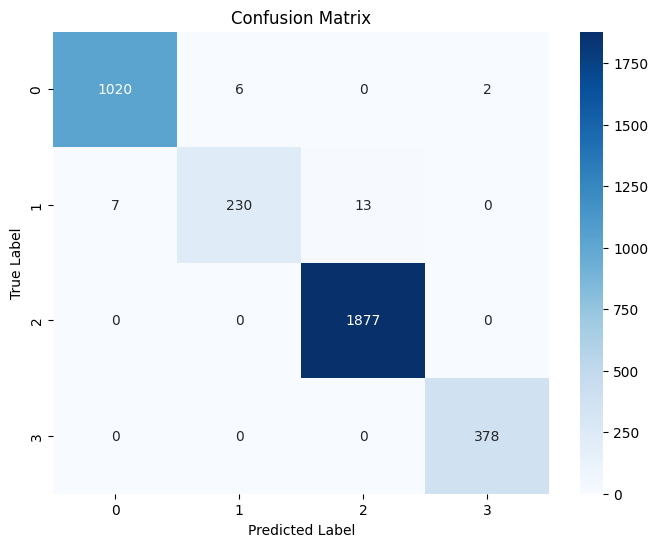

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on validation data
y_pred = np.argmax(global_model.predict(X_test), axis=1)  # Get class with highest probability
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices if needed

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [26]:
list1 = localacc[0::3]  # Positions 0, 3, 6, 9...
list2 = localacc[1::3]  # Positions 1, 4, 7, 10...
list3 = localacc[2::3]  # Positions 2, 5, 8, 11...

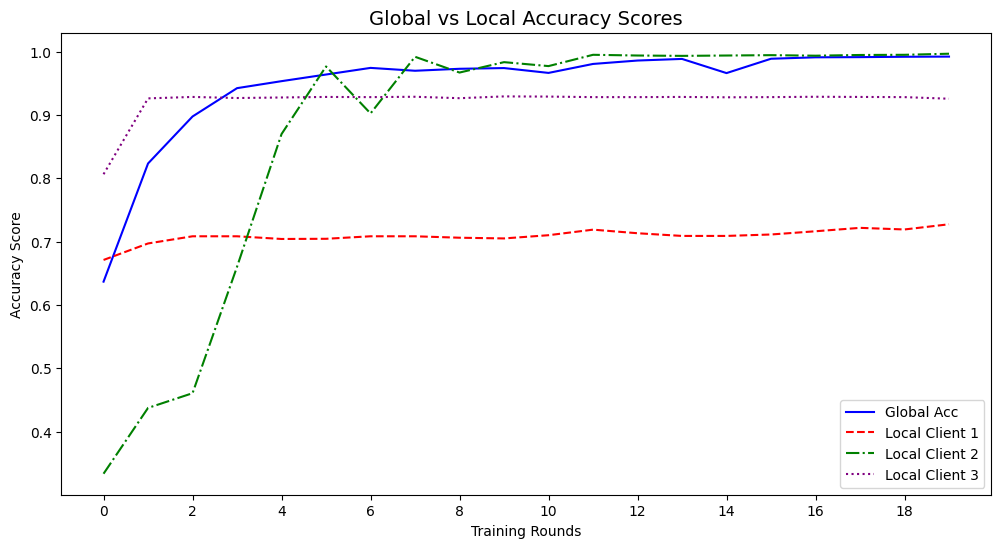

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis values (assuming IoU values over rounds/steps)
x = np.arange(len(globalacc))

# Increase figure size for better visualization
plt.figure(figsize=(12, 6))  # Wider aspect ratio

# Plotting with different line styles
plt.plot(x, globalacc, linestyle='-', color='b', label='Global Acc')       # Solid line
plt.plot(x, list1, linestyle='--', color='r', label='Local Client 1')       # Dashed line
plt.plot(x, list2, linestyle='-.', color='g', label='Local Client 2')       # Dash-dot line
plt.plot(x, list3, linestyle=':', color='purple', label='Local Client 3')   # Dotted line

# Title and legend
plt.title("Global vs Local Accuracy Scores", fontsize=14)
plt.xlabel("Training Rounds")
plt.ylabel("Accuracy Score")
plt.legend()

# Set x-axis interval to 2
plt.xticks(np.arange(0, len(globalacc), 2))

# Show the plot
plt.show()
